Proof of scoring using x,y coordinate of dart tip

In [28]:
import cv2
import matplotlib.pyplot as plt
import os

cur_dir = os.getcwd()
parent_dir = os.path.dirname(cur_dir)
print(cur_dir)
print(parent_dir)

/Users/zach/Desktop/SDP/SmokingDartsv2/core
/Users/zach/Desktop/SDP/SmokingDartsv2


Load image of darts representing edge of scoring area, and an image of a dart representing center of scoring area.

Image of nodart


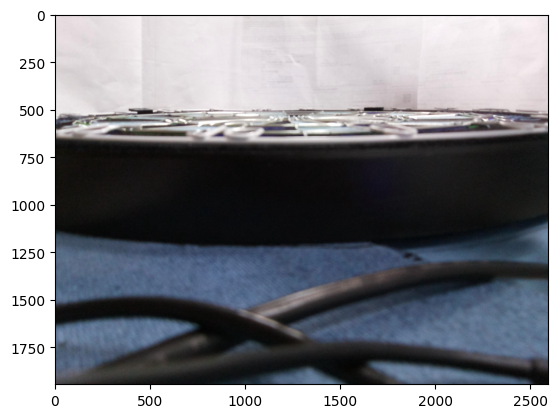

Image of dartx


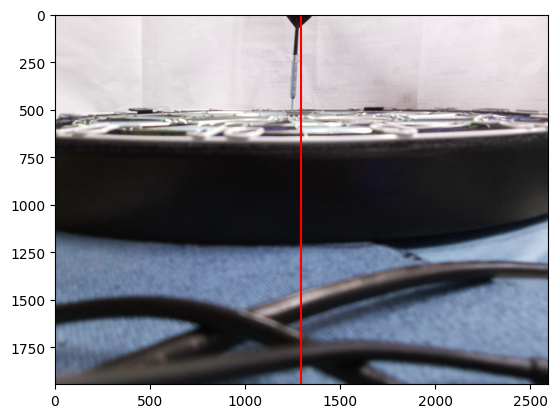

Image of darty


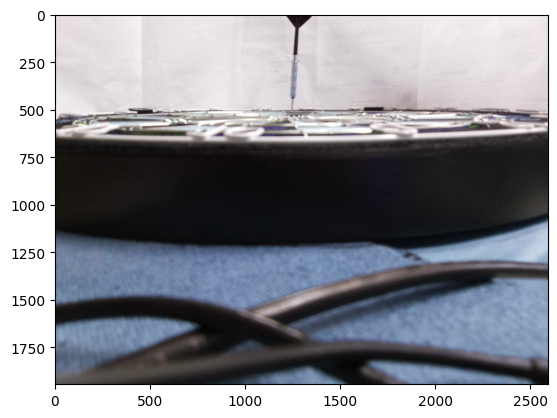

Image Resolution: 2592 x 1944


In [44]:
# load images
nodart = cv2.imread(os.path.join(parent_dir, 'images/scrap', '25.jpg'))
dartx = cv2.imread(os.path.join(parent_dir, 'images/scrap', '30.jpg'))
darty = cv2.imread(os.path.join(parent_dir, 'images/scrap', '30.jpg'))

# display images
print("Image of nodart")
plt.imshow(nodart)
plt.show()
print("Image of dartx")
# draw a vertical line in the center of image dartx
plt.plot([dartx.shape[1]//2, dartx.shape[1]//2], [0, dartx.shape[0]], 'r-')
plt.imshow(dartx)
plt.show()
print("Image of darty")
plt.imshow(darty)
plt.show()


image_height, image_width, channels = nodart.shape
print('Image Resolution: {} x {}'.format(image_width, image_height))



Difference Image Marked Up

Image of dartx


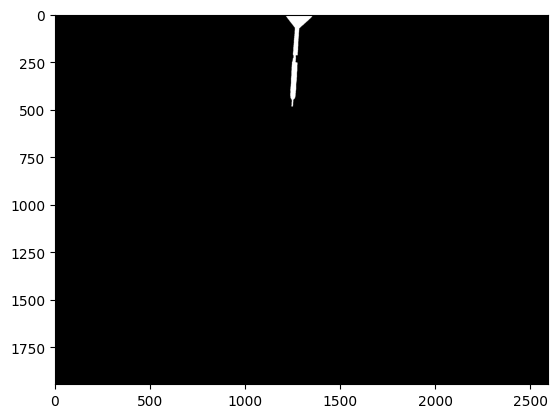

Image of darty


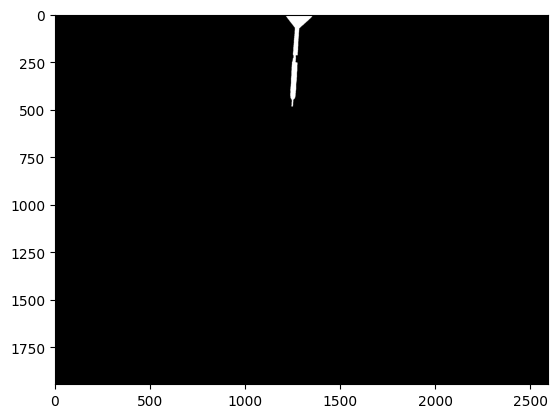

coordinates:  [1247.15, 1247.15]


In [41]:
from dart_tip_coordinate import *

def show_diff_image(dart, nodart):
    # dartboard
    db = DartboardImage("x", dart, last_img=nodart)
    diff = db.get_diff_to_last_img()

    # set bottom 3/4 of image to 0
    diff[diff.shape[0]//4:, :] = 0
    # set top half of image to 0
    #diff[:diff.shape[0]//2, :] = 0

    # set bottom 1/4 of image to 0 
    #diff[diff.shape[0]//2:diff.shape[0]//4:, :] = 0

    # opencv dilation
    kernel = np.ones((5,5),np.uint8)
    diff = cv2.dilate(diff.astype('uint8'),kernel,iterations = 1)

    # opencv erosion
    kernel = np.ones((5,5),np.uint8)
    diff = cv2.erode(diff.astype('uint8'),kernel,iterations = 1)

    # get the tip
    isolated_dart_tip = isolate_dart_tip(diff)
    y_coordinate, x_coordinate = center_of_mass(isolated_dart_tip)

    # show image diff
    plt.imshow(diff, cmap='gray')
    plt.show()
    return x_coordinate


print("Image of dartx")
x = show_diff_image(dartx, nodart)
print("Image of darty")
y = show_diff_image(darty, nodart)
coordinates = [x, y]
print("coordinates: ", coordinates)

Determine coordinates of these boundries.

In [42]:
def get_dart_tip_coordinates(dart, last_img):
    # dartboard
    db = DartboardImage("x", dart, last_img=last_img)
    diff = db.get_diff_to_last_img()

    # set bottom 3/4 of image to 0
    diff[diff.shape[0]//4:, :] = 0

    # opencv dilation
    kernel = np.ones((5,5),np.uint8)
    diff = cv2.dilate(diff.astype('uint8'),kernel,iterations = 1)

    # opencv erosion
    kernel = np.ones((5,5),np.uint8)
    diff = cv2.erode(diff.astype('uint8'),kernel,iterations = 1)

    # get the tip
    isolated_dart_tip = isolate_dart_tip(diff)
    y_coordinate, x_coordinate = center_of_mass(isolated_dart_tip)

    return x_coordinate

dart_coordinates = [get_dart_tip_coordinates(dartx, nodart), get_dart_tip_coordinates(darty, nodart)]
print("dart_coordinates:", dart_coordinates)


dart_coordinates: [1247.15, 1247.15]


Determine Angle of Camera to Dart
![](Trogan_Image.png)

In [43]:
def angle_from_camera_to_dart(coordinates, image_width = 2592, fov=62.2):
    angle = [0, 0]
    angle[0] = coordinates[0] / image_width * fov
    angle[1] = coordinates[1] / image_width * fov
    return angle

dart_angles = angle_from_camera_to_dart(dart_coordinates)
print("dart_angles:", dart_angles)



dart_angles: [29.92775077160494, 29.92775077160494]


In [33]:
center_of_board = 1247.15
print("center of board:", center_of_board)
board_length_pixels = 2175
board_length_cm = 34.29
pixels_per_cm = board_length_pixels/board_length_cm
print("pixels_per_cm: ", pixels_per_cm)

center_to_x_pixel = abs(dart_coordinates[0] - center_of_board)
center_to_y_pixel = abs(dart_coordinates[1] - center_of_board)
center_to_x_cm = center_to_x_pixel/pixels_per_cm
center_to_y_cm = center_to_y_pixel/pixels_per_cm
print(center_to_x_cm, center_to_y_cm)



center of board: 1247.15
pixels_per_cm:  63.42957130358705
25.38015239281898 25.38015239281898


In [34]:
from scoreboard import get_score

# get score
score = get_score(center_to_x_cm, center_to_y_cm)
print("score: ", score)

Missed. Try Again.
score:  0
